# Download the MNIST Dataset

In [12]:
import torch
import torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to range [-1, 1]
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 60000
Test dataset size: 10000


# Split the Dataset for Multiple Clients

In [3]:
from torch.utils.data import random_split

num_clients = 5

# Split the training dataset into `num_clients` parts
client_datasets = random_split(train_dataset, [len(train_dataset) // num_clients] * num_clients)

# Check the size of each client's dataset
for i, client_data in enumerate(client_datasets):
    print(f"Client {i+1} dataset size: {len(client_data)}")


Client 1 dataset size: 12000
Client 2 dataset size: 12000
Client 3 dataset size: 12000
Client 4 dataset size: 12000
Client 5 dataset size: 12000


# Visualize the Data

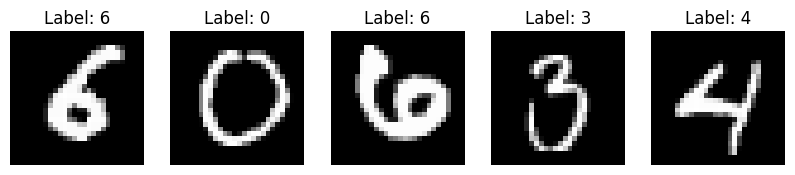

In [6]:
import matplotlib.pyplot as plt

def visualize_data(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Visualize data from the first client's dataset
visualize_data(client_datasets[0])


# Defining the Model

In [7]:
import torch.nn as nn

# Defining a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input layer
            nn.ReLU(),               # Activation function
            nn.Linear(128, 10)       # Output layer (10 classes)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        return self.fc(x)

# Initializing the model
global_model = SimpleNN()
print(global_model)


SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


#  Local Training Function

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Local training function
def train_local_model(model, data, epochs=2, batch_size=32, lr=0.01):
    model.train()
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights


# Global Aggregation Function

In [10]:
def average_weights(client_models):
    global_model = client_models[0]
    global_state_dict = global_model.state_dict()

    # Average weights from all client models
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_model.state_dict()[key] for client_model in client_models], dim=0).mean(dim=0)

    global_model.load_state_dict(global_state_dict)
    return global_model


# Federated Averaging Loop

In [13]:
# Federated learning loop
num_rounds = 5
local_epochs = 2

for round in range(num_rounds):
    print(f"--- Round {round+1} ---")
    client_models = []

    for client_data in client_datasets:
        # Clone the global model for local training
        local_model = SimpleNN()
        local_model.load_state_dict(global_model.state_dict())

        # Train locally
        train_local_model(local_model, client_data, epochs=local_epochs)
        client_models.append(local_model)

    # Aggregate local models to update the global model
    global_model = average_weights(client_models)

print("Federated learning completed!")


--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
Federated learning completed!


# Evaluating the Global Model

In [26]:
from torch.utils.data import DataLoader

def evaluate_model(model, test_data):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    return accuracy



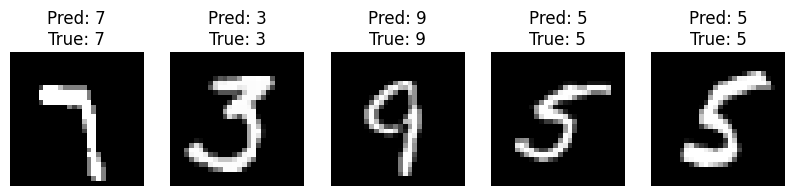

In [18]:
def visualize_predictions(model, test_data):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=5, shuffle=True)
    inputs, labels = next(iter(test_loader))

    with torch.no_grad():
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(inputs[i].squeeze(), cmap='gray')
        ax.set_title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}")
        ax.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(global_model, test_dataset)


# Trying out different variations in distributed setting

(a) Client Participation:Currently, all clients might be participating in each round. Trying to reduce client participation per round (e.g., select a random subset of clients for training in each round).

In [19]:
import random

def select_clients(client_datasets, fraction=0.5):
    num_selected = int(len(client_datasets) * fraction)
    return random.sample(client_datasets, num_selected)

# Example: Select 50% of clients for a round
selected_clients = select_clients(client_datasets, fraction=0.5)


(b) Increasing the model complexity

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flatten after 2x2 pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        return self.fc2(x)


In [23]:
global_model = CNN()  # Initialize the global model with the new architecture

In [24]:
local_model = CNN()  # Use the new CNN model for local training

In [27]:
for round in range(num_rounds):
    print(f"--- Round {round+1} ---")

    # Selecting a fraction of clients to participate
    selected_clients = select_clients(client_datasets, fraction=0.5)
    client_models = []

    for client_data in selected_clients:
        # Clone the global model for local training
        local_model = CNN()
        local_model.load_state_dict(global_model.state_dict())

        # Train locally
        train_local_model(local_model, client_data, epochs=local_epochs)
        client_models.append(local_model)

    # Aggregating local models to update the global model
    global_model = average_weights(client_models)

    # Evaluating global model after the round
    accuracy = evaluate_model(global_model, test_dataset)  # Accuracy is now returned
    accuracies.append(accuracy)
    print(f"Round {round+1} Accuracy: {accuracy:.2f}%")

print("Federated learning completed!")


--- Round 1 ---
Round 1 Accuracy: 95.15%
--- Round 2 ---
Round 2 Accuracy: 96.21%
--- Round 3 ---
Round 3 Accuracy: 97.21%
--- Round 4 ---
Round 4 Accuracy: 97.71%
--- Round 5 ---
Round 5 Accuracy: 97.73%
Federated learning completed!


# Experimenting with different client participations

In [28]:
# Different participation levels to experiment with
participation_levels = [0.25, 0.5, 0.75, 1.0]
results = {}

for fraction in participation_levels:
    print(f"\n=== Experiment with {int(fraction * 100)}% Client Participation ===")
    accuracies = []  # Reset accuracies for this participation level

    for round in range(num_rounds):
        print(f"--- Round {round+1} ---")

        selected_clients = select_clients(client_datasets, fraction=fraction)
        client_models = []

        for client_data in selected_clients:
            # Clone the global model for local training
            local_model = CNN()
            local_model.load_state_dict(global_model.state_dict())

            # Train locally
            train_local_model(local_model, client_data, epochs=local_epochs)
            client_models.append(local_model)

        # Aggregating local models to update the global model
        global_model = average_weights(client_models)

        # Evaluating global model after the round
        accuracy = evaluate_model(global_model, test_dataset)  # Accuracy is now returned
        accuracies.append(accuracy)
        print(f"Round {round+1} Accuracy: {accuracy:.2f}%")

    # Store results for this participation level
    results[int(fraction * 100)] = accuracies
    print(f"Completed experiment for {int(fraction * 100)}% client participation.")

for level, acc in results.items():
    print(f"\nClient Participation: {level}%")
    print(f"Accuracies over rounds: {acc}")



=== Experiment with 25% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 97.98%
--- Round 2 ---
Round 2 Accuracy: 98.18%
--- Round 3 ---
Round 3 Accuracy: 98.03%
--- Round 4 ---
Round 4 Accuracy: 98.33%
--- Round 5 ---
Round 5 Accuracy: 98.47%
Completed experiment for 25% client participation.

=== Experiment with 50% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 98.60%
--- Round 2 ---
Round 2 Accuracy: 98.59%
--- Round 3 ---
Round 3 Accuracy: 98.55%
--- Round 4 ---
Round 4 Accuracy: 98.79%
--- Round 5 ---
Round 5 Accuracy: 98.74%
Completed experiment for 50% client participation.

=== Experiment with 75% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 98.75%
--- Round 2 ---
Round 2 Accuracy: 98.71%
--- Round 3 ---
Round 3 Accuracy: 98.77%
--- Round 4 ---
Round 4 Accuracy: 98.84%
--- Round 5 ---
Round 5 Accuracy: 98.89%
Completed experiment for 75% client participation.

=== Experiment with 100% Client Participation ===
--- Round 1 ---
Round 1 Accurac

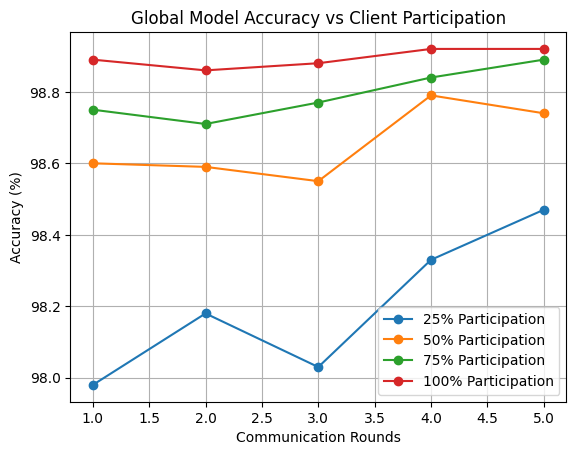

In [29]:
# Plot accuracy trends
import matplotlib.pyplot as plt

for level, acc in results.items():
    rounds = list(range(1, num_rounds + 1))
    plt.plot(rounds, acc, marker='o', label=f"{level}% Participation")

plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Global Model Accuracy vs Client Participation')
plt.legend()
plt.grid()
plt.show()
